# Introduction
This Notebook contains my work for analyzing a 100km transect in the Southern Ocean. The goal is to identify Lee waves from the measurements and then estimate the energy fluxes and transport driven by these lee waves. 



In [55]:
# Load Data and relevant modules
%matplotlib inline
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import data_load
import gsw
import oceans as oc
import pandas as pd


ladcp, ctd = data_load.load_data()
strain = np.genfromtxt('strain.csv', delimiter=',')
wl_max=1200
wl_min=400
ctd_bin_size=1500
ladcp_bin_size=1500



# Inspect profiles

# Extracting Wave Components
This section uses spectral analysis to estimate kinetic and potential energies lee waves. Using a minimum and maximum vertical wavelength as integration limits, I estimate the energetics of target wavelengths. These limits were determined qualitatively by estimative vertical size of features in profiles (how big are the wiggles). 

In [56]:
# These functions run the necessary calucations for spectral analysis
def PowerDens(data, dz, wlmax, wlmin, axis=0, grid=False, detrend='constant'):
    """
    Using periodogram function to estimate power spectral density

    PARAMETERS:
    data: data array for input (assumes column wise data (axis=0))
    dz: vertical sampling rate
    wlmax: maximimum vertical wavelength integration limit
    wlmin: minimum vertical wavelength integration limit

    RETURN:
    variance: The integrated psd of the profiles


    """

    mgrid, Psd = sig.periodogram(data, fs=1/dz, axis=axis,
                                 nfft=len(data), detrend=detrend,
                                 window='hanning', scaling='density')

    # Integration limits set by minimum and maximum vertical wavelength
    int_limit = np.logical_and(mgrid <= (1)/wlmin, mgrid >= (1)/wlmax)

    # Integrate between set limits
    variance = np.trapz(Psd[int_limit], x=mgrid[int_limit])

    if grid:
        return variance, mgrid, Psd
    else:
        return variance


def PE_strain(N2, z, strain, wl_min, wl_max, bin_idx, detrend='constant'):
    """
    Calculate internal wave potential energy based on isopycnal displacements
    and using neutral densities. (optional to do this) The function should work
    the same with normal density and an accompanying reference density profile.

    update:
    Right now this uses strain x dz with strain calculated from alex's code on
    the bray and fofonoff leveling method. it seems to work better than when I
    do it with my own density calculations (gets crazy numbers)

    """
    # Assumes that strain is the gradient version of isopycnal displacements
    dz = np.nanmean(np.diff(z, axis=0))
    m = (2*np.pi)/(np.nanmean([wl_max, wl_min]))
    eta = (strain/m)
    eta_psd = []

    # Use periodogram and integrate between target wavelengths
    eta1 = np.full((bin_idx.shape[0], eta.shape[1]), np.nan)
    for k, cast in enumerate(eta.T):
        for i, binIn in enumerate(bin_idx):
            eta1[i, k], f_grid, psd = PowerDens(cast[binIn], dz, wl_max,
                                            wl_min, grid=True, detrend=detrend)
            eta_psd.append(psd)

    eta_psd = np.vstack(eta_psd)


    # Calculate mean Buoyancy Frequency for each bin
    N2mean = []
    for binIn in bin_idx:
        N2mean.append(np.nanmean(N2[binIn, :], axis=0))

    N2mean = np.vstack(N2mean)

    PE = 0.5*1027*eta1*N2mean

    return PE, f_grid, eta_psd, N2mean


def KE_UV(U, V, z, bin_idx, wl_min, wl_max, lc=150, detrend=False):
    """

    Internal wave kinetic energy

    """

    # Clean Up velocity data (u' = U - u_bar)
    Upoly = []
    for cast in U.T:
        fitrev = oc.vert_polyFit(cast, z[:, 0], 100, deg=1)
        Upoly.append(fitrev)

    Upoly = np.vstack(Upoly).T
    U = U - Upoly
    
    dz = 8  # This is the vertical spacing between measurements in metres. 
    lc = lc  # This is the cut off vertical scale in metres, the filter will remove variability smaller than this.
    mc = 1./lc  # Cut off wavenumber.
    normal_cutoff = mc*dz*2.  # Nyquist frequency is half 1/dz.
    a1, a2 = sig.butter(4, normal_cutoff, btype='lowpass')  # This specifies you use a lowpass butterworth filter of order 4, you can use something else if you want
    for i in range(U.shape[1]):
        mask = ~np.isnan(U[:,i])
        U[mask,i] = sig.filtfilt(a1, a2, U[mask,i])

    Vpoly = []

    for cast in V.T:
        fitrev = oc.vert_polyFit(cast, z[:, 0], 100, deg=1)
        Vpoly.append(fitrev)

    Vpoly = np.vstack(Vpoly).T
    V = V - Vpoly
    
    for i in range(V.shape[1]):
        mask = ~np.isnan(U[:,i])
        V[mask,i] = sig.filtfilt(a1, a2, V[mask,i])
    dz = np.nanmean(np.gradient(z, axis=0))
    KE_psd = []

    # Use periodogram and integrate between target wavelengths
    Pu = np.full((bin_idx.shape[0],U.shape[1]), np.nan)
    Pv = np.full((bin_idx.shape[0],U.shape[1]), np.nan)
    for k, (Ui, Vi) in enumerate(zip(U.T, V.T)):
        for i, binIn in enumerate(bin_idx):
            Pu[i,k], f_grid, psd = PowerDens(Ui[binIn], dz, wl_max,\
                                      wl_min, grid=True, detrend=detrend)
            Pv[i,k], f_grid, psd1 = PowerDens(Ui[binIn], dz, wl_max,\
                                      wl_min, grid=True, detrend=detrend)
            KE_psd.append(.5*1027*(psd + psd1))

    KE_psd = np.vstack(KE_psd)


    # New Version
    KE = 0.5*1027*(Pu + Pv)
    clean  = KE_psd < 1e-8
    KE_psd[clean] = np.nan

    return KE, f_grid, KE_psd, U, V

# Run Functions on data loaded in.

In [57]:
U, V, p_ladcp = oc.loadLADCP(ladcp)
S, T, p_ctd, lat, lon = oc.loadCTD(ctd)
SA = gsw.SA_from_SP(S, p_ctd, lon, lat)
CT = gsw.CT_from_t(SA, T, p_ctd)
N2, dump = gsw.stability.Nsquared(SA, CT, p_ctd, lat)

maxDepth = 4000
idx_ladcp = p_ladcp[:, -1] <= maxDepth
idx_ctd = p_ctd[:, -1] <= maxDepth

strain = strain[idx_ctd, :]
S = S[idx_ctd,:]
p_ctd = p_ctd[idx_ctd, :]
U = U[idx_ladcp, :]
V = V[idx_ladcp, :]
p_ladcp = p_ladcp[idx_ladcp, :]
# Bin CTD data
ctd_bins = oc.binData(S, p_ctd[:, 0], ctd_bin_size)
# Bin Ladcp Data
ladcp_bins = oc.binData(U, p_ladcp[:, 0], ladcp_bin_size)

# Depth and lat/long grids
depths = np.vstack([np.nanmean(p_ctd[binIn]) for binIn in ctd_bins])
dist = gsw.distance(lon, lat)
dist = np.cumsum(dist)/1000
dist = np.append(0,dist)


# Calculate Potential Energy
z = -1*gsw.z_from_p(p_ctd, lat)
PE, PE_grid, eta_psd, N2mean = PE_strain(N2, z, strain,\
                                         wl_min, wl_max, ctd_bins)

# Calculate Kinetic Energy
z = -1*gsw.z_from_p(p_ladcp, lat)
KE, KE_grid, KE_psd, Uprime, Vprime = KE_UV(U, V, z, ladcp_bins,
                            wl_min, wl_max, lc=wl_min-50, detrend=False)

# Total Kinetic Energy
Etotal = (KE + PE) # Multiply by density to get Joules

In [58]:
# wave components
f = np.nanmean(gsw.f(lat))

# version 2 omega calculation
omega = f*np.sqrt(((KE+PE)/(KE-PE)))



# version 2 omega calculation
omega2 = ((f**2)*((KE+PE)/(KE-PE)))
rw = KE/PE
w0 = ((f**2)*((rw+1)/(rw-1)))
m = (2*np.pi)/np.mean((wl_min, wl_max))

# version 1 kh calculation
kh = m*np.sqrt(((f**2 - omega**2)/(omega**2 - N2mean)))

# version 2 kh calculation
khi = (m/np.sqrt(N2mean))*(np.sqrt(omega2 - f**2))
mask = kh == 0
kh[mask]= np.nan
lambdaH = 1e-3*(2*np.pi)/kh

/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


### Plotting velocity anomalies (version 1)


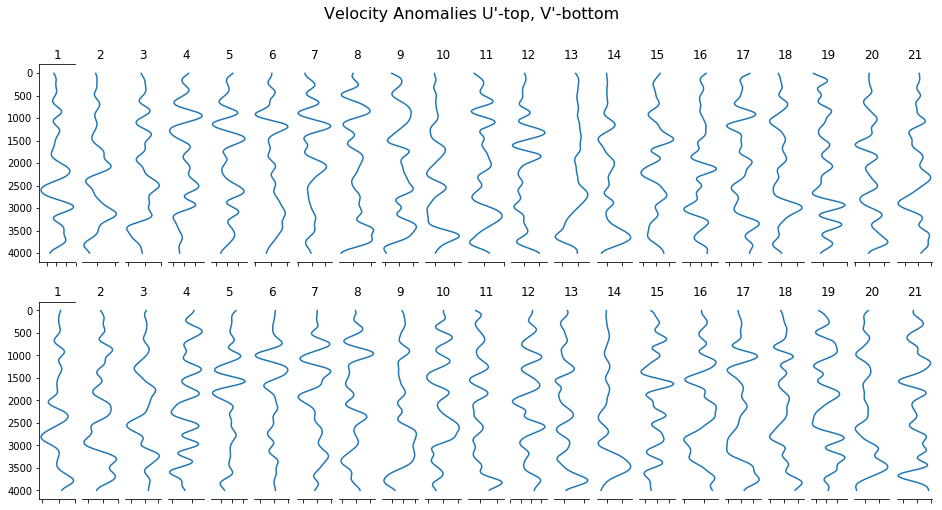

In [59]:
plt.figure(figsize=[16,8])

for i in range(lambdaH.shape[1]):
    
    if i == 0:
        plt.subplot(2,U.shape[1],i+1)
        plt.plot(Uprime[:,i], p_ladcp)
        plt.title(str(i+1))
        ax = plt.gca()
        plt.gca().invert_yaxis()
        ax.spines['right'].set_color(None)
        plt.setp( ax.get_xticklabels(), visible=False)
    else:
        plt.subplot(2,U.shape[1],i+1)
        plt.plot(Uprime[:,i], p_ladcp)
        ax = plt.gca()
        plt.title(str(i+1))
        plt.gca().invert_yaxis()
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color(None) 
        ax.spines['right'].set_color(None)
        ax.spines['left'].set_color(None)
        ax.get_yaxis().set_visible(False)
        plt.setp( ax.get_xticklabels(), visible=False)


for i in range(lambdaH.shape[1]):
    if i == 0:
        plt.subplot(2,U.shape[1],(i+1)+U.shape[1])
        plt.plot(Vprime[:,i], p_ladcp)
        plt.title(str(i+1))
        ax = plt.gca()
        plt.gca().invert_yaxis()

        ax.spines['right'].set_color(None)
        plt.setp( ax.get_xticklabels(), visible=False)
    else:
        plt.subplot(2,U.shape[1],(i+1)+U.shape[1])
        plt.plot(Vprime[:,i], p_ladcp)
        ax = plt.gca()
        plt.title(str(i+1))
        plt.gca().invert_yaxis()

        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color(None) 
        ax.spines['right'].set_color(None)
        ax.spines['left'].set_color(None)
        ax.get_yaxis().set_visible(False)
        plt.setp( ax.get_xticklabels(), visible=False)
        
    plt.suptitle("Velocity Anomalies U'-top, V'-bottom", fontsize=16)
    plt.savefig('velocity_anomalies.png', bbox_inches='tight')



### Plotting velocity  Magntidude anomalies (version 1)


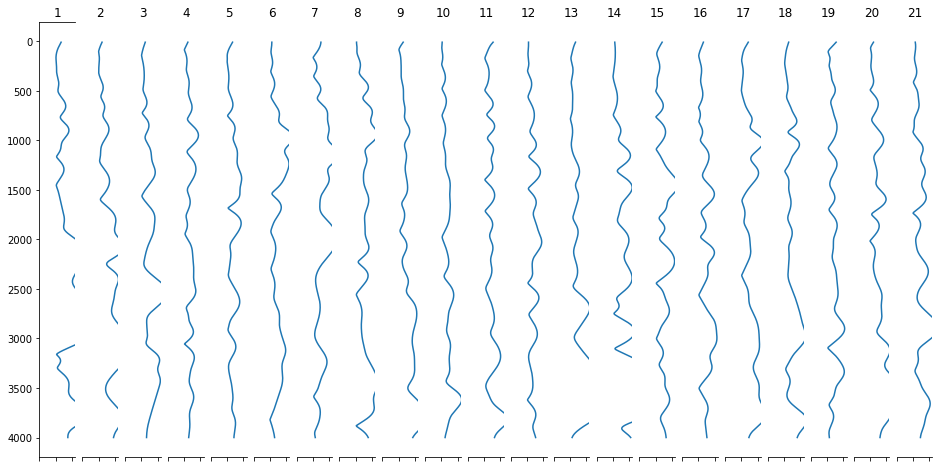

In [60]:
plt.figure(figsize=[16,8])

for i in range(lambdaH.shape[1]):
    
    Y1 = Uprime[:,i]
    Y2 = Vprime[:,i]
    Y = np.sqrt(Y1**2 + Y2**2)
    if i == 0:
        plt.subplot(1,U.shape[1],i+1)
        plt.plot(Y, p_ladcp)
        plt.title(str(i+1))
        ax = plt.gca()
        plt.gca().invert_yaxis()
        ax.spines['right'].set_color(None)
        ax.set_xlim(-.05,.06)
        plt.setp( ax.get_xticklabels(), visible=False)
    else:
        plt.subplot(1,U.shape[1],i+1)
        plt.plot(Y, p_ladcp)
        ax = plt.gca()
        plt.title(str(i+1))
        ax.set_xlim(-.05,.06)
        plt.gca().invert_yaxis()
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color(None) 
        ax.spines['right'].set_color(None)
        ax.spines['left'].set_color(None)
        ax.get_yaxis().set_visible(False)
        plt.setp( ax.get_xticklabels(), visible=False)


### Use Pandas dataframes to visualize wave properties calculated for each bin. Depths show middle depth for bin, columns indicate station number

In [61]:
lambdaH = pd.DataFrame(lambdaH)
lambdaH.index = np.squeeze(depths)

lambdaH

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,NaN,15.123711,89.278105,47.689428,38.636088,13.22951,50.438311,10.322441,15.676875,2.769875,...,51.105512,10.104598,15.171999,10.082688,NaN,11.77165,20.397379,NaN,9.62094,4.945731
2250.0,27.512101,30.730234,82.458839,5.427677,22.878419,NaN,NaN,NaN,NaN,NaN,...,NaN,6.267828,3.115012,NaN,NaN,NaN,NaN,NaN,NaN,26.039970
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
kh = pd.DataFrame(kh)
kh.index = np.squeeze(depths)
kh

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,NaN,0.000415,0.000070,0.000132,0.000163,0.000475,0.000125,0.000609,0.000401,0.002268,...,0.000123,0.000622,0.000414,0.000623,NaN,0.000534,0.000308,NaN,0.000653,0.001270
2250.0,0.000228,0.000204,0.000076,0.001158,0.000275,NaN,NaN,NaN,NaN,NaN,...,NaN,0.001002,0.002017,NaN,NaN,NaN,NaN,NaN,NaN,0.000241
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
omega2 = pd.DataFrame(np.sqrt(omega2))
omega2.index = np.squeeze(depths)
omega2

/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,NaN,0.000152,0.000118,0.000121,0.000122,0.000155,0.00012,0.00017,0.000142,0.000438,...,0.000119,0.000163,0.000137,0.000155,NaN,0.000144,0.000127,NaN,0.000153,0.000226
2250.0,0.000124,0.000122,0.000118,0.000214,0.000124,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000181,0.000292,NaN,NaN,NaN,NaN,NaN,NaN,0.000121
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
Etotal = pd.DataFrame(Etotal)
Etotal.index = np.squeeze(depths)
Etotal

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,0.121260,0.169650,0.050369,0.121637,0.202741,0.130983,0.273048,0.060491,0.087285,0.125597,...,0.149324,0.024801,0.537811,0.361275,0.109404,0.029193,0.031525,0.062864,0.29559,0.145392
2250.0,0.908528,0.719933,0.087192,0.031588,0.057260,0.010662,NaN,NaN,NaN,NaN,...,0.120824,0.062266,0.122657,NaN,NaN,NaN,NaN,NaN,NaN,0.149413
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Momentum Fluxes


In [65]:
omega = pd.DataFrame((omega))
omega.index = np.squeeze(depths)
omega



,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,NaN,-0.000152,-0.000118,-0.000121,-0.000122,-0.000155,-0.00012,-0.00017,-0.000142,-0.000438,...,-0.000119,-0.000163,-0.000137,-0.000155,NaN,-0.000144,-0.000127,NaN,-0.000153,-0.000226
2250.0,-0.000124,-0.000122,-0.000118,-0.000214,-0.000124,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.000181,-0.000292,NaN,NaN,NaN,NaN,NaN,NaN,-0.000121
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
khi = pd.DataFrame(khi)
khi.index = np.squeeze(depths)
khi

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,NaN,0.000414,0.000070,0.000131,0.000162,0.000473,0.000124,0.000605,0.000399,0.002173,...,0.000123,0.000618,0.000412,0.000619,NaN,0.00053,0.000306,NaN,0.000648,0.001248
2250.0,0.000227,0.000204,0.000076,0.001140,0.000273,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000989,0.001942,NaN,NaN,NaN,NaN,NaN,NaN,0.000240
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


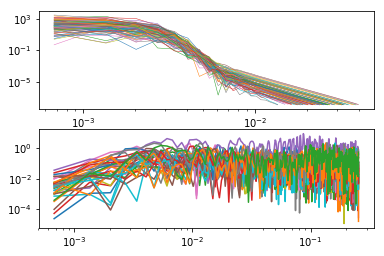

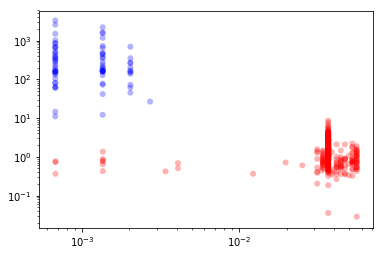

In [67]:
plt.figure()
plt.subplot(211)
plt.loglog(KE_grid, KE_psd.T, linewidth=.5)
plt.subplot(212)
plt.loglog(PE_grid, .5*np.nanmean(N2)*eta_psd.T)

plt.figure()
Kemax = np.nanmax(KE_psd, axis=1)
kespots = np.nanargmax(KE_psd, axis=1)
ax = plt.gca()
ax.scatter(KE_grid[kespots],Kemax , c='blue', alpha=0.3, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')

Kemax = np.nanmax(.5*np.nanmean(N2)*eta_psd.T, axis=1)
kespots = np.nanargmax(.5*np.nanmean(N2)*eta_psd.T, axis=1)
ax = plt.gca()
ax.scatter(PE_grid[kespots],Kemax , c='red', alpha=0.3, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.figure(figsize=[16,8])

